In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier


# **Data Understanding**

In [ ]:
df = pd.read_csv('diabetes.csv')

In [ ]:
print(df.dtypes)

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [ ]:
df.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [ ]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [ ]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)

In [ ]:
def missing_plot(df):
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

    fig = px.bar(
        missing_df,
        x=missing_df.index,
        y='Missing Count',
        text=missing_df['Missing %'].round(2),
        labels={'x': 'Features', 'Missing Count': 'Số lượng thiếu'},
        title='Missing Values (Count & %)'
    )
    fig.update_traces(textposition='outside')
    fig.show()


In [ ]:
missing_plot(df)

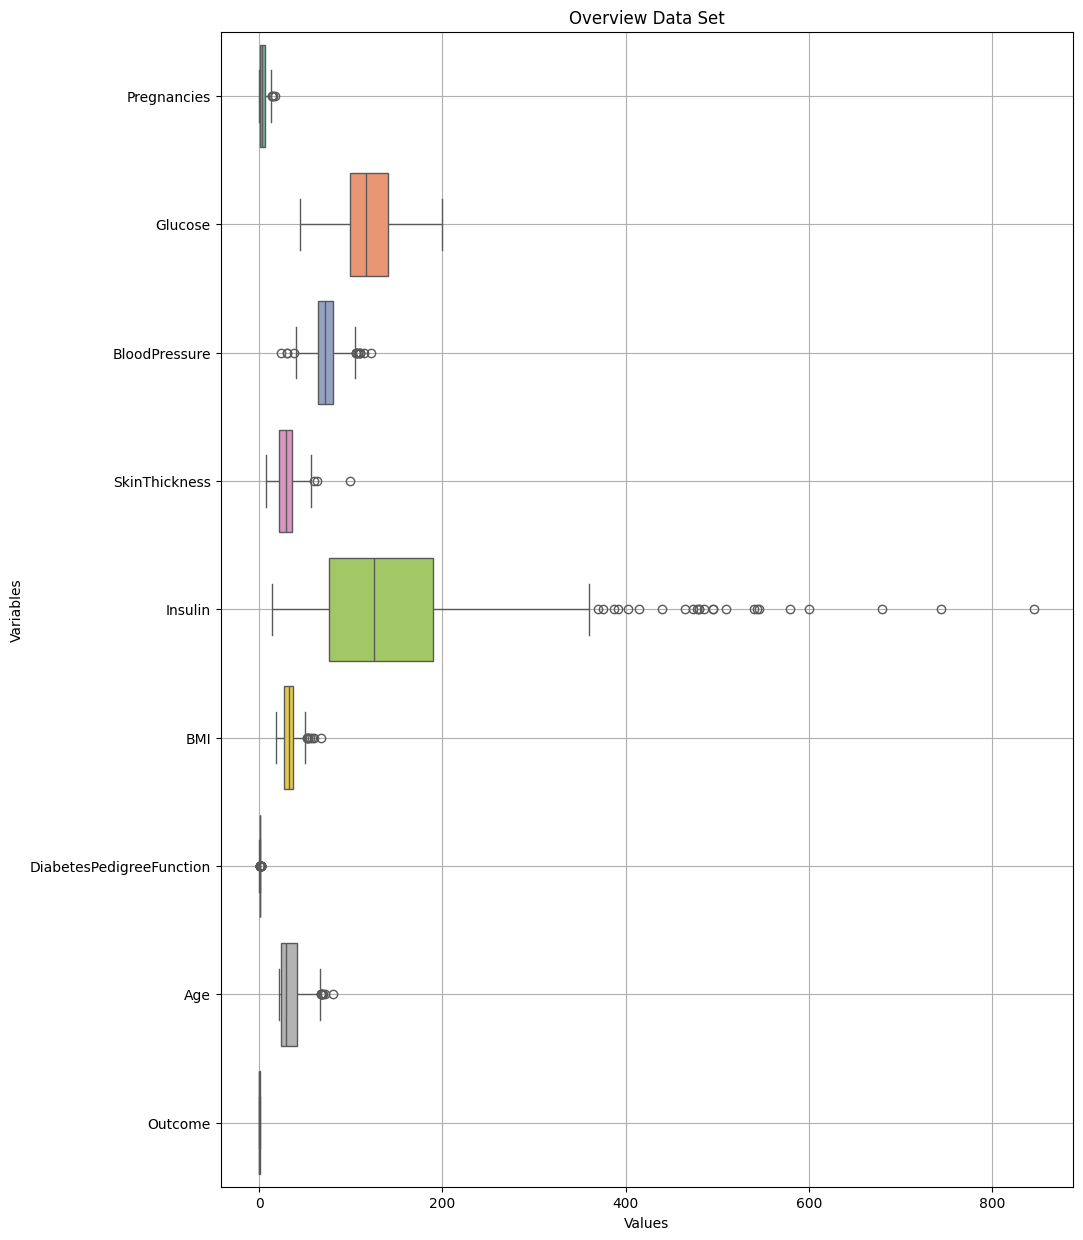

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 15))
sns.boxplot(data=df, orient='h', palette='Set2')
plt.title("Overview Data Set")
plt.xlabel("Values")
plt.ylabel("Variables")
plt.grid(True)
plt.show()

In [ ]:
def correlation_plot(data):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='viridis', fmt=".2f")
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

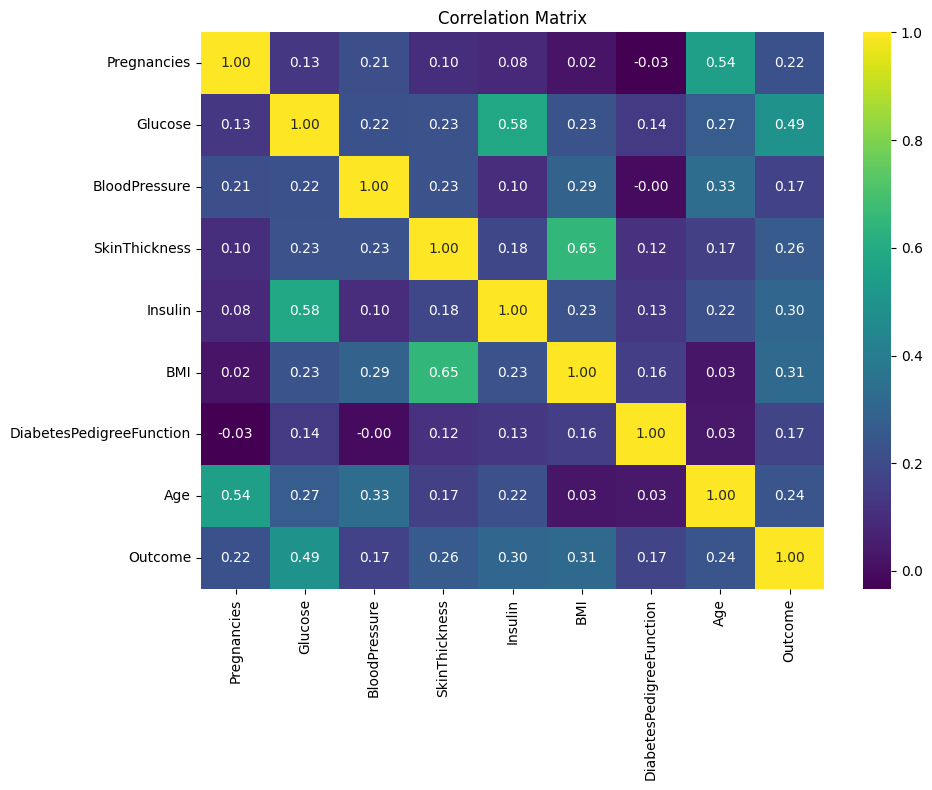

In [ ]:
correlation_plot(df)


To replace missing values, we'll use median by target (Outcome)

In [ ]:
cols_to_fill = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in cols_to_fill:
    df[col] = df[col].fillna(df.groupby('Outcome')[col].transform('median'))

# **Feature Engineering**

In [ ]:
def plot_feat1_feat2(feat1, feat2):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=feat1, y=feat2, hue='Outcome', palette={0: '#7EC0EE', 1: '#FFD700'})
    plt.title(f'{feat1} vs {feat2}')
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.legend(title='Outcome', labels=['Diabetic', 'Healthy'])
    plt.tight_layout()
    plt.show()

In [ ]:
def barplot(var_select, sub):

    diabetic = df[df['Outcome'] == 1]
    healthy = df[df['Outcome'] == 0]

    diabetic_counts = diabetic[var_select].value_counts()
    healthy_counts = healthy[var_select].value_counts()

    total_counts = df[var_select].value_counts()
    diabetes_percent = diabetic_counts / total_counts * 100

    plt.figure(figsize=(10, 6))

    plt.bar(healthy_counts.index, healthy_counts.values,
            label='Healthy', color='lightblue', alpha=0.8)
    plt.bar(diabetic_counts.index, diabetic_counts.values,
            bottom=healthy_counts.values, label='Diabetic',
            color='gold', alpha=0.8)

    plt.plot(diabetes_percent.index, diabetes_percent.values,
             color='black', marker='o', label='% Diabetic')


    plt.title(f'{var_select} {sub}')
    plt.xlabel(var_select)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

In [ ]:
def plot_pie(var_select, sub):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Diabetic pie chart
    diabetic_counts = df[df['Outcome'] == 1][var_select].value_counts()
    ax1.pie(diabetic_counts.values, labels=diabetic_counts.index, autopct='%1.1f%%')
    ax1.set_title("Diabetic")

    # Healthy pie chart
    healthy_counts = df[df['Outcome'] == 0][var_select].value_counts()
    ax2.pie(healthy_counts.values, labels=healthy_counts.index, autopct='%1.1f%%')
    ax2.set_title("Healthy")

    fig.suptitle(f"{var_select} distribution by target\n{sub}")
    plt.tight_layout()
    plt.show()

In [ ]:
features = [col for col in df.columns if col != 'Outcome']

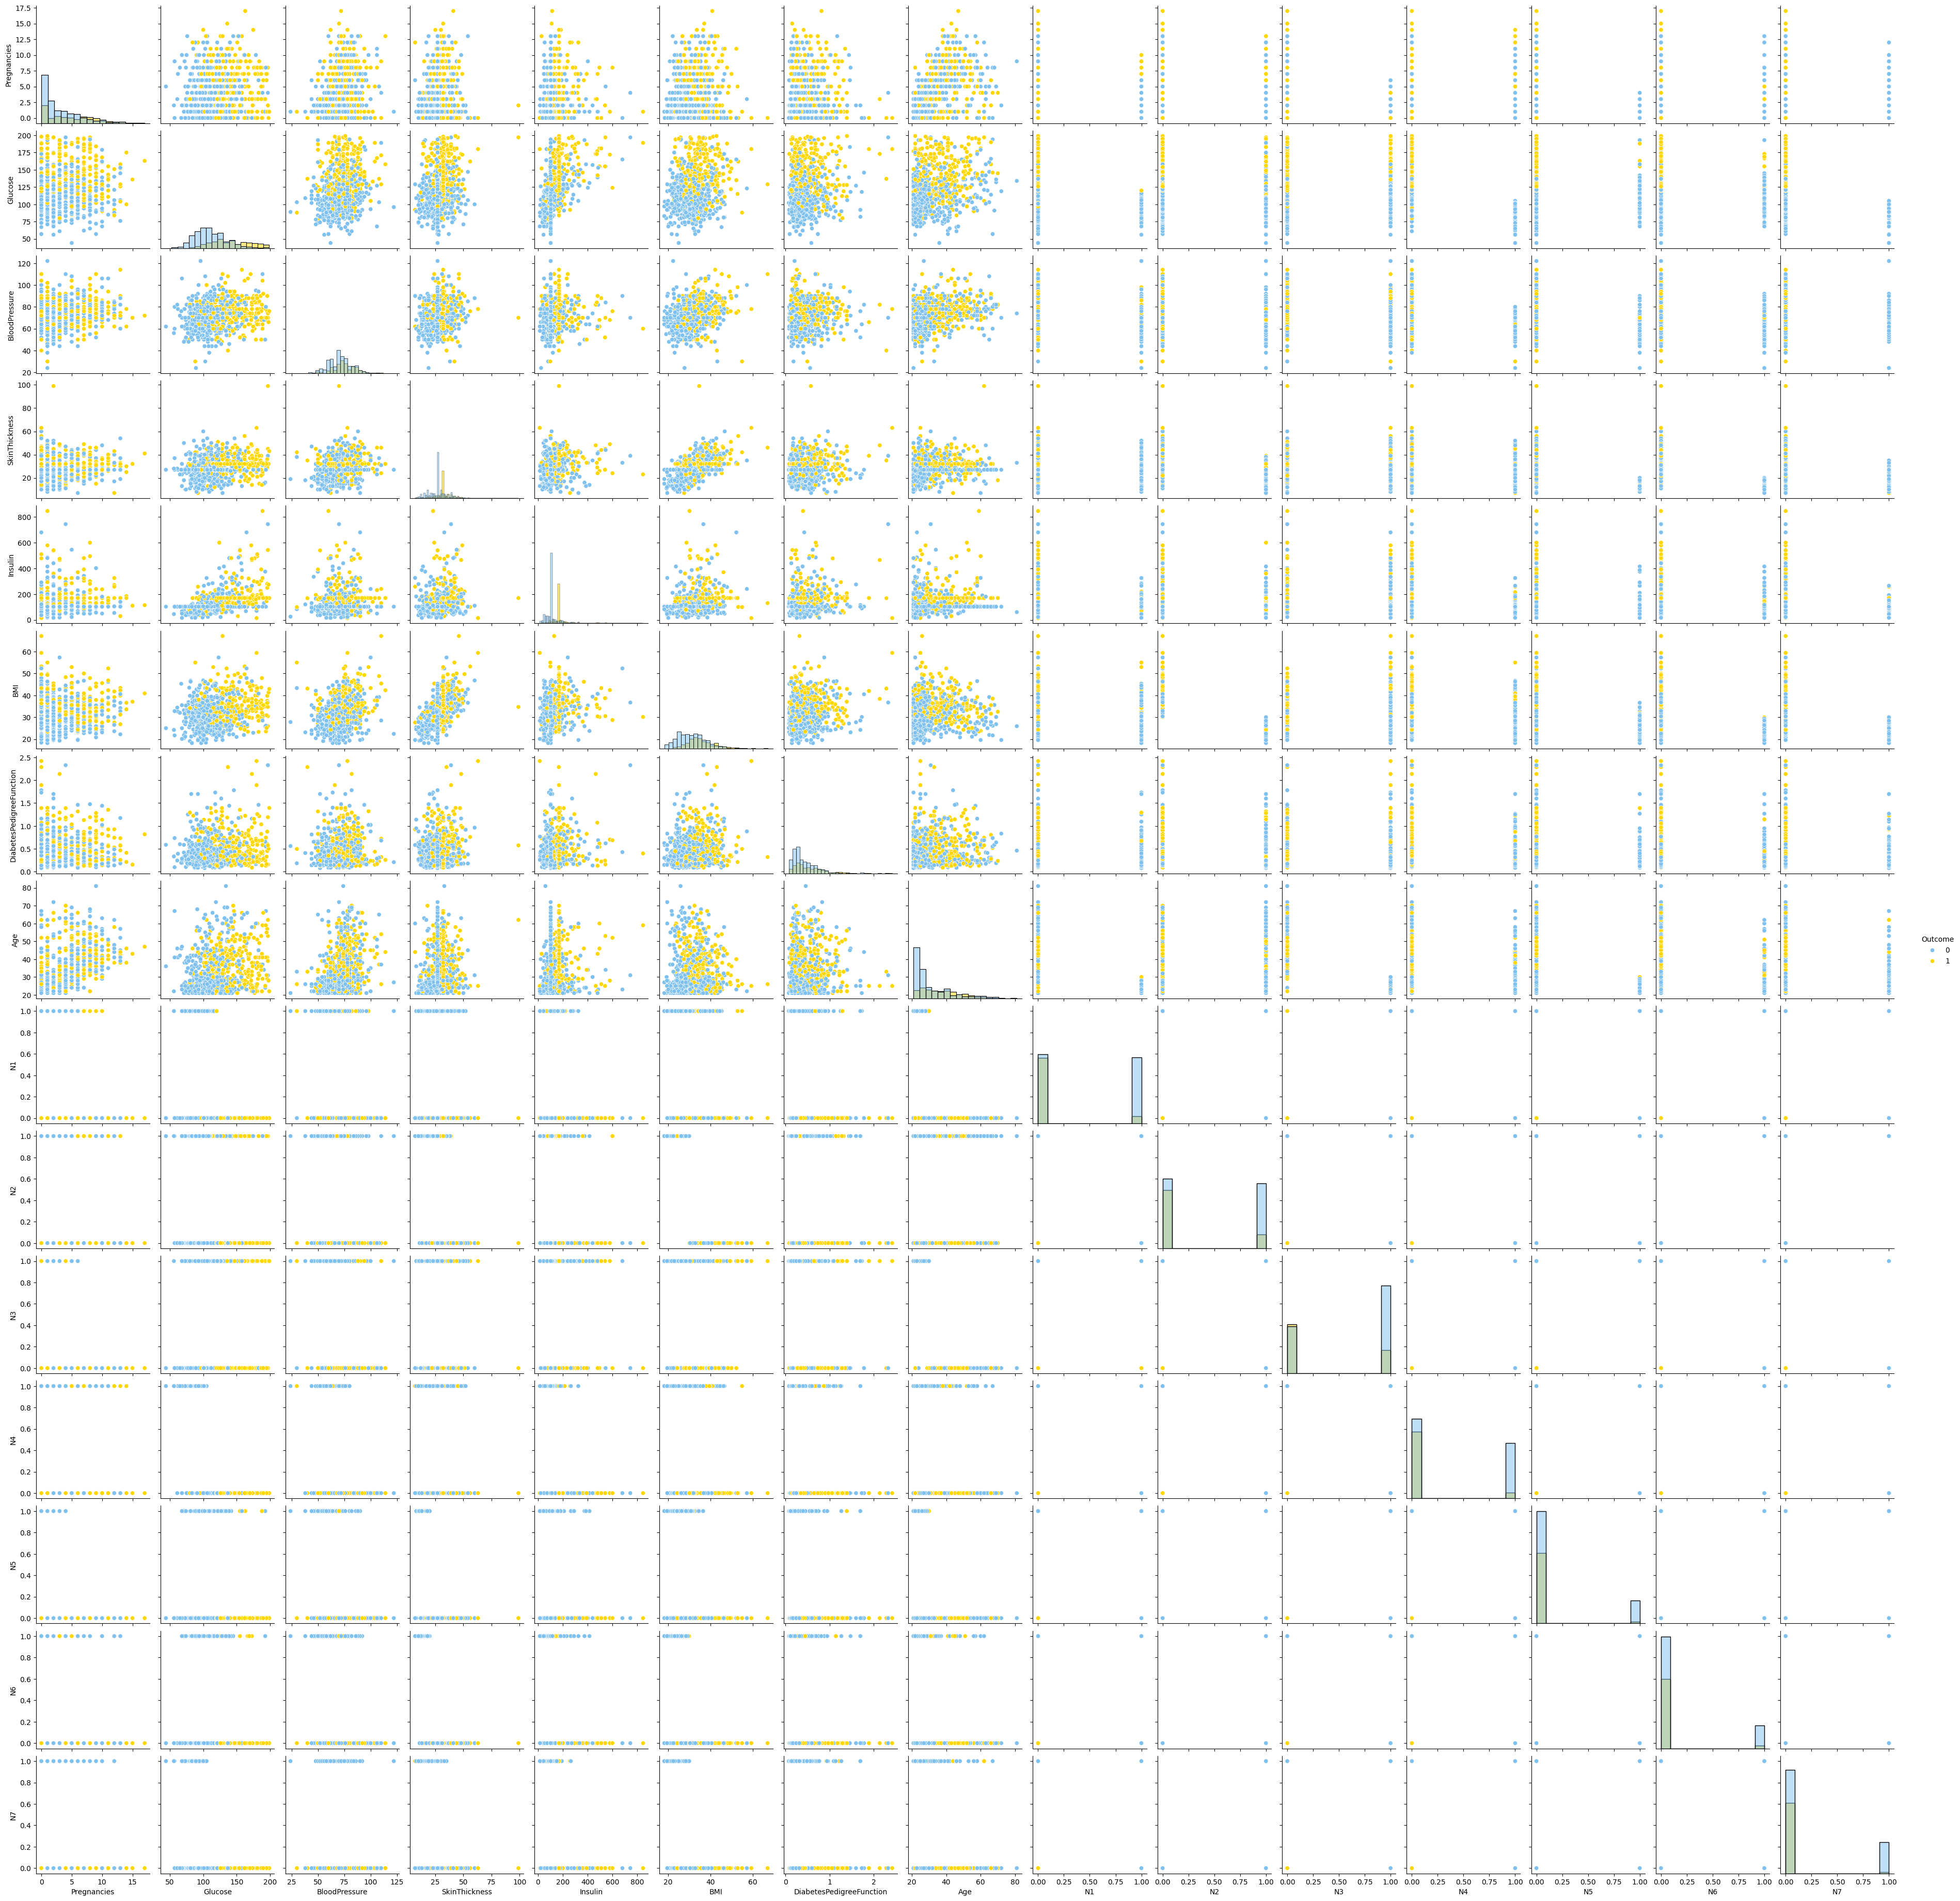

In [ ]:
sns.pairplot(df, hue='Outcome', diag_kind='hist', palette={0: '#7EC0EE', 1: '#FFD700'})

### The correlation of "Age" and "Glucose" with "Diabetes": https://medlineplus.gov/ency/patientinstructions/000086.htm

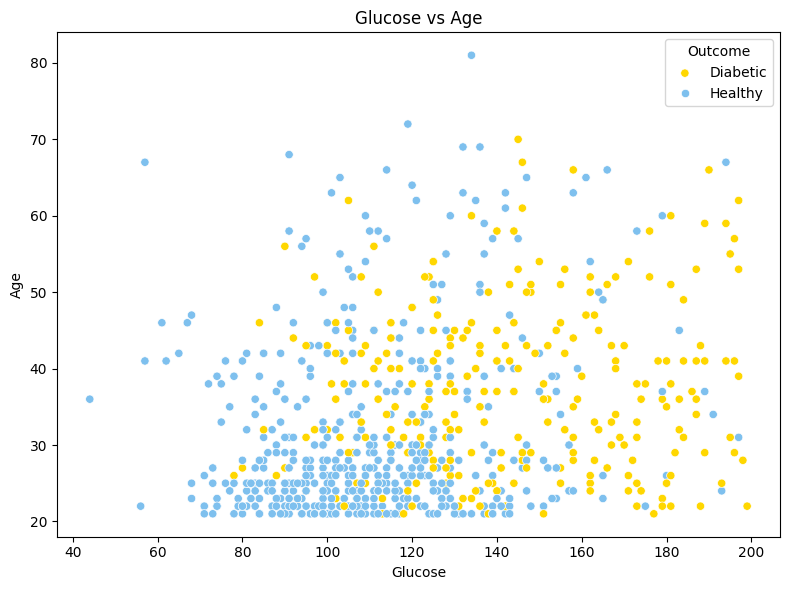

In [ ]:
plot_feat1_feat2('Glucose','Age')

Healthy persons are concentrate with an age <= 30 and glucose <= 120

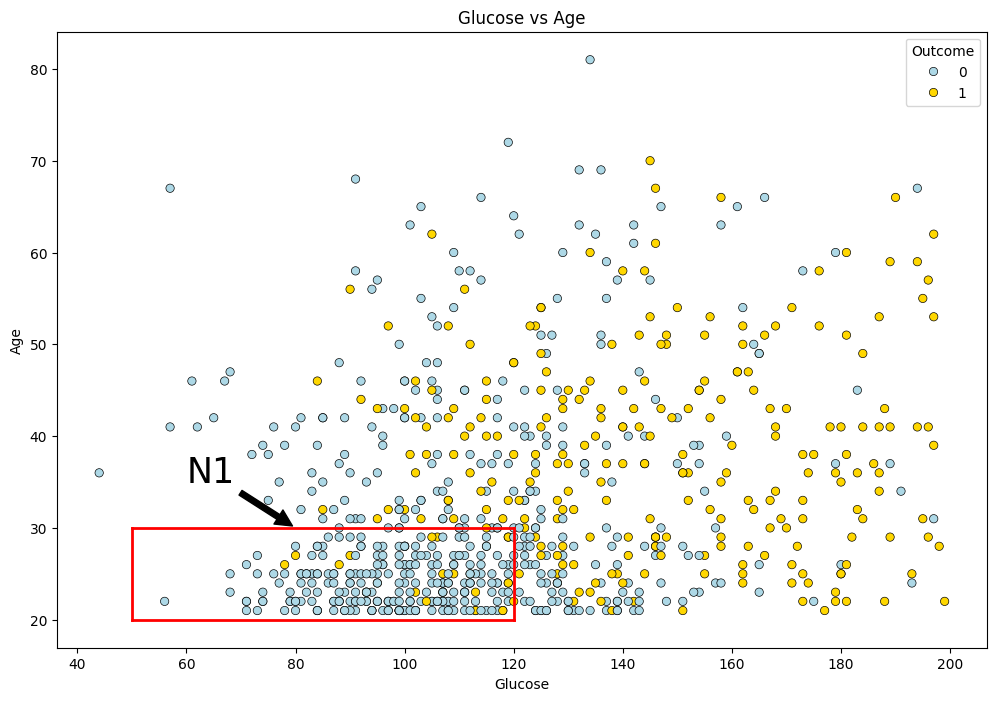

In [ ]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = df['Glucose'], y = df['Age'], hue = "Outcome",
                    data = df, palette = palette, edgecolor=edgecolor)

plt.annotate('N1', size=25, color='black', xy=(80, 30), xytext=(60, 35),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([50, 120], [30, 30], linewidth=2, color = 'red')
plt.plot([120, 120], [20, 30], linewidth=2, color = 'red')
plt.plot([50, 120], [20, 20], linewidth=2, color = 'red')
plt.plot([50, 50], [20, 30], linewidth=2, color = 'red')
plt.title('Glucose vs Age')
plt.show()

In [ ]:
df.loc[:,'N1']=0
df.loc[(df['Age']<=30) & (df['Glucose']<=120), 'N1'] = 1

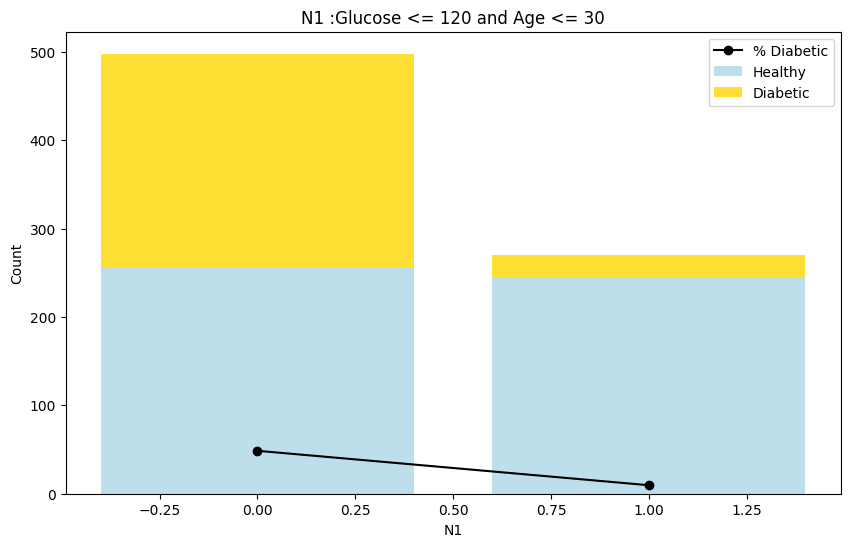

In [ ]:
barplot('N1', ':Glucose <= 120 and Age <= 30')

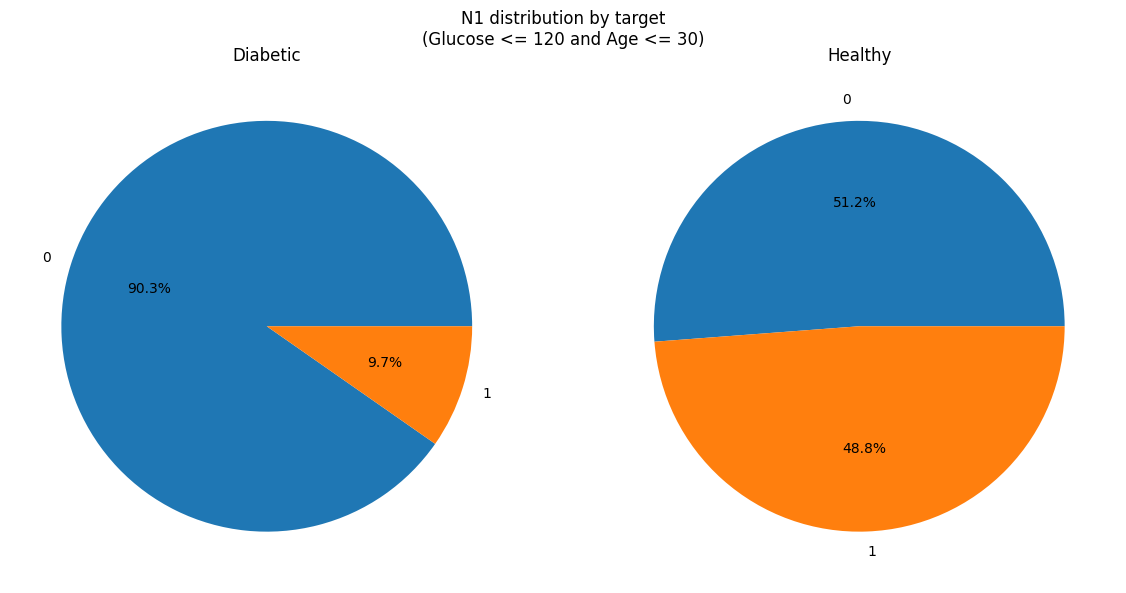

In [ ]:
plot_pie('N1', '(Glucose <= 120 and Age <= 30)')

### BMI: According to wikipedia "The body mass index (BMI) or Quetelet index is a value derived from the mass (weight) and height of an individual. The BMI is defined as the body mass divided by the square of the body height, and is universally expressed in units of kg/m2, resulting from mass in kilograms and height in metres.". 30 kg/m² is the limit to obesity

In [ ]:
df.loc[:,'N2']=0
df.loc[(df['BMI']<=30),'N2']=1

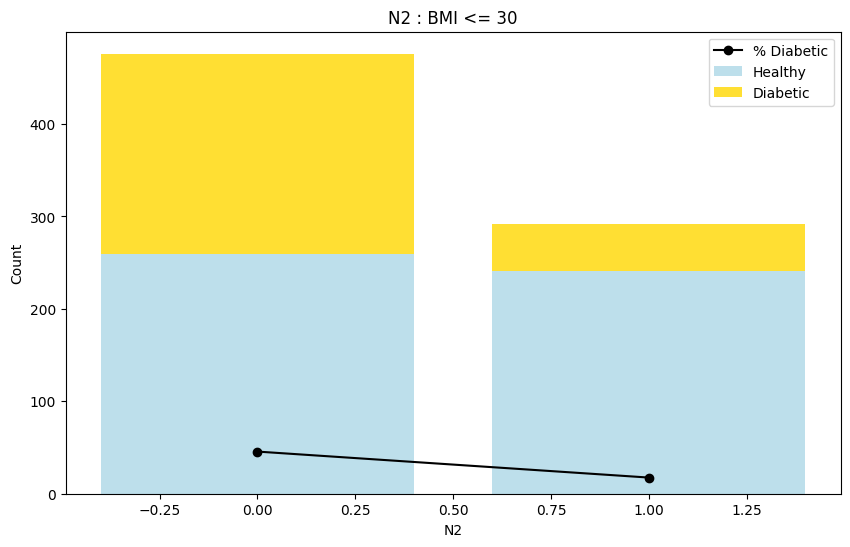

In [ ]:
barplot('N2', ': BMI <= 30')

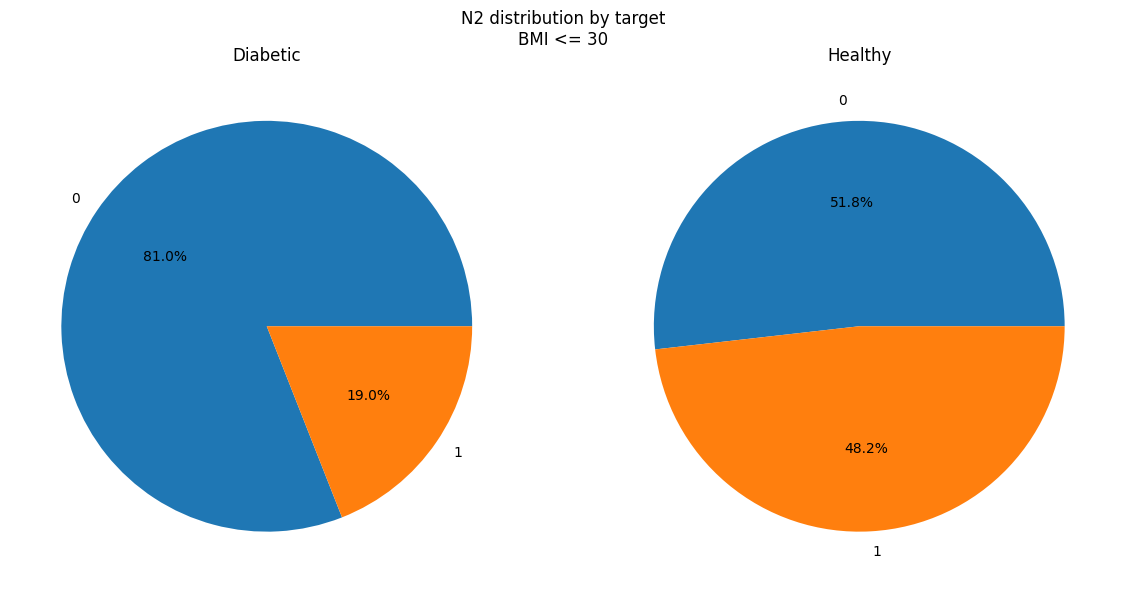

In [ ]:
plot_pie('N2', 'BMI <= 30')

### Pregnancy and Age: https://www.cdc.gov/mmwr/volumes/72/wr/mm7201a4.htm. The percentage of mothers giving birth who received a diagnosis of diabetes during pregnancy (gestational diabetes) increased from 6.0% in 2016 to 8.3% in 2021. Increases in gestational diabetes were seen in each maternal age group, and rates rose steadily with maternal age; in 2021, the rate for mothers aged ≥40 years (15.6%) was nearly six times as high as the rate for mothers aged <20 years (2.7%).

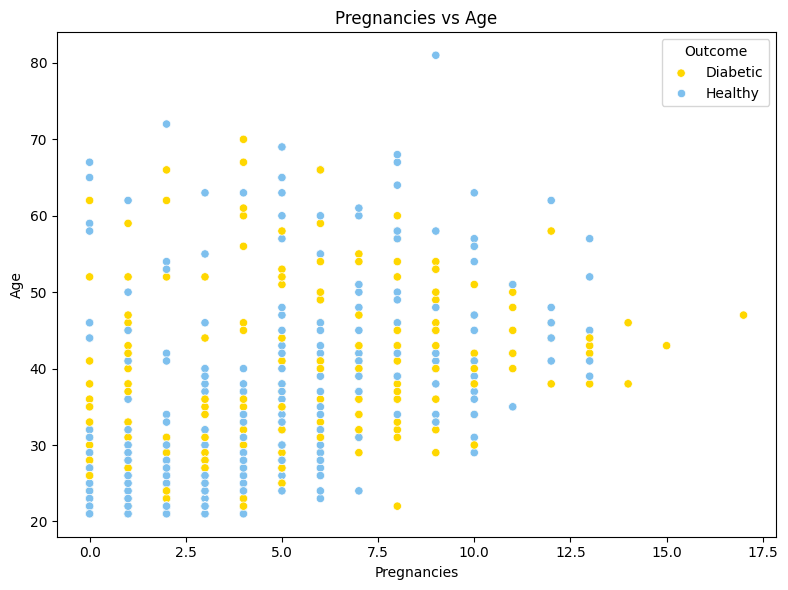

In [ ]:
plot_feat1_feat2('Pregnancies','Age')

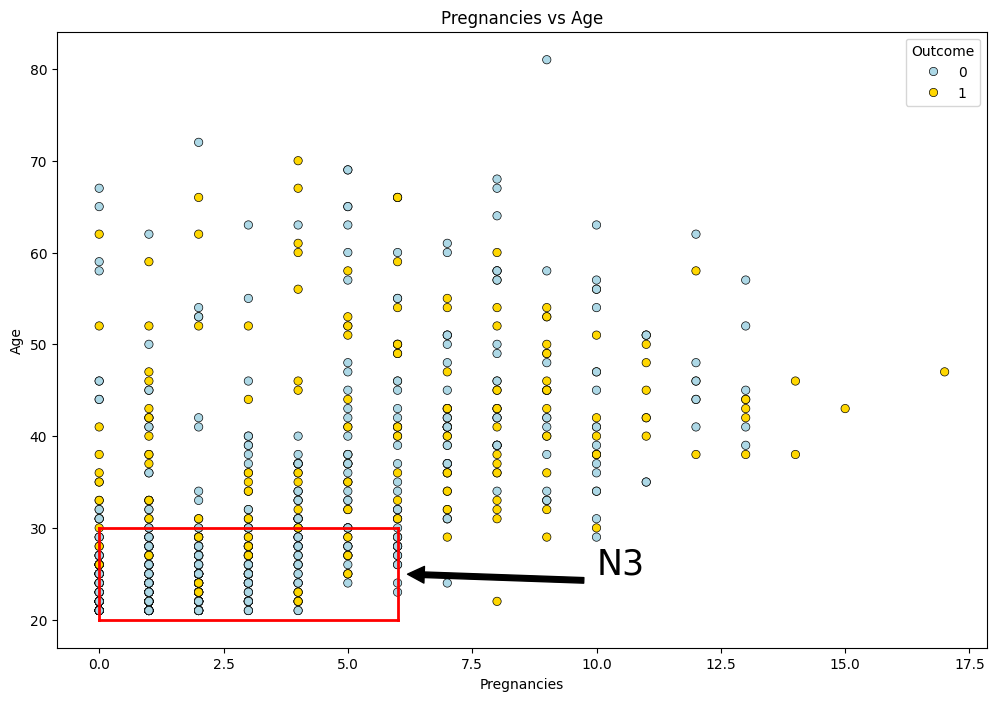

In [ ]:
palette = {0: 'lightblue', 1: 'gold'}
edgecolor = 'black'
fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = df['Pregnancies'], y = df['Age'], hue = "Outcome",
                    data = df, palette = palette, edgecolor=edgecolor)
plt.annotate('N3', size=25, color='black', xy=(6, 25), xytext=(10, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot([0, 6], [30, 30], linewidth=2, color = 'red')
plt.plot([6, 6], [20, 30], linewidth=2, color = 'red')
plt.plot([0, 6], [20, 20], linewidth=2, color = 'red')
plt.plot([0, 0], [20, 30], linewidth=2, color = 'red')
plt.title('Pregnancies vs Age')
plt.show()

Healthy person focuses on pregnancies < 6 and age <30

In [ ]:
df.loc[:,'N3'] = 0
df.loc[(df['Age']<=30) & (df['Pregnancies']<=6),'N3'] = 1

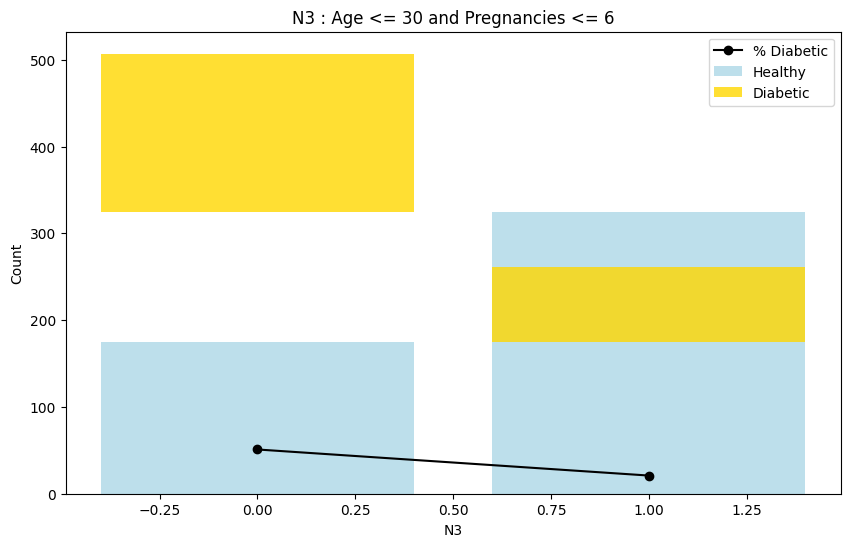

In [ ]:
barplot('N3', ': Age <= 30 and Pregnancies <= 6')

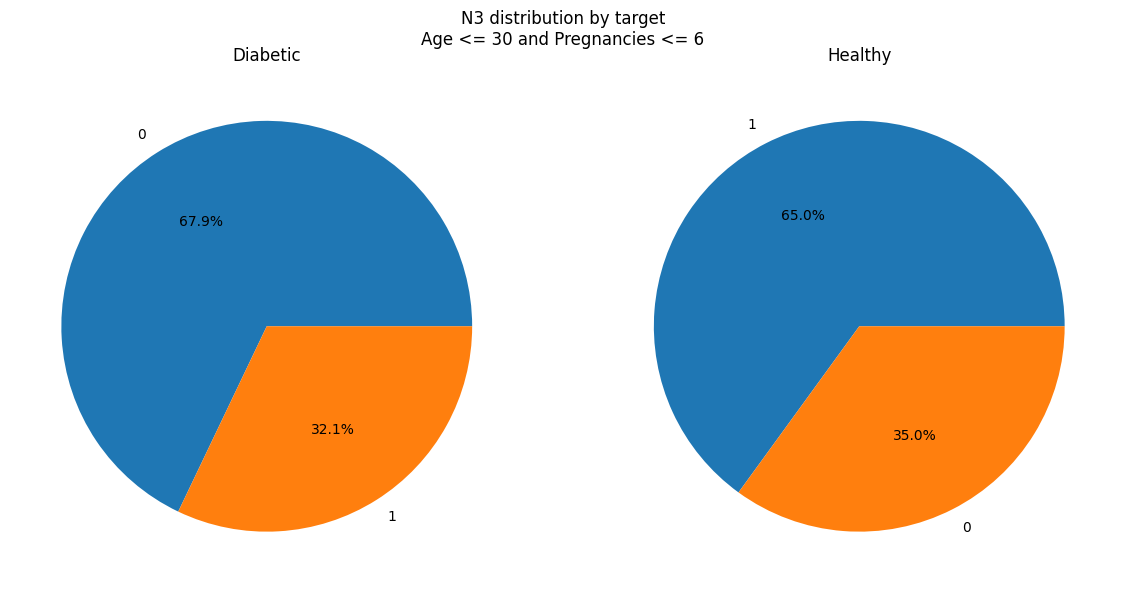

In [ ]:
plot_pie('N3', 'Age <= 30 and Pregnancies <= 6')

### Glucose and BloodPressure

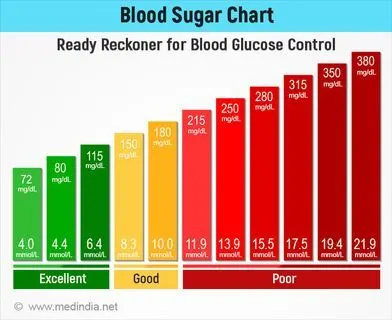

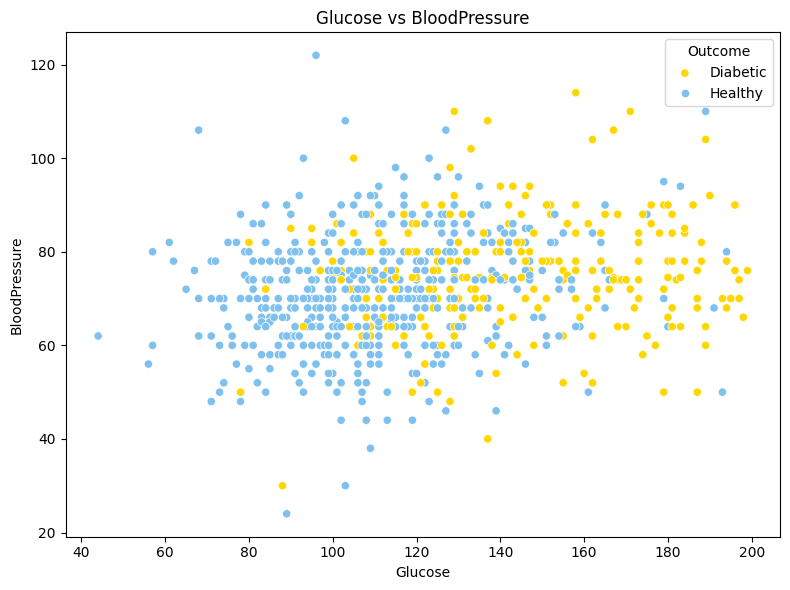

In [ ]:
plot_feat1_feat2('Glucose','BloodPressure')

Healthy persons are concentrate with an blood pressure <= 80 and glucose <= 105

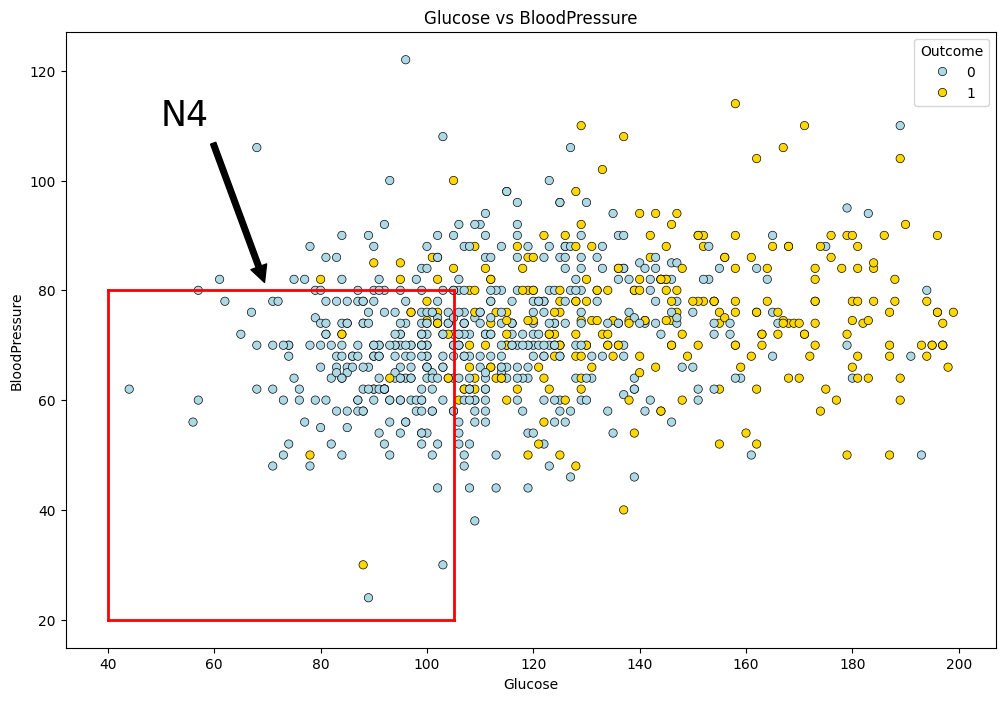

In [ ]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = df['Glucose'], y = df['BloodPressure'], hue = "Outcome",
                    data = df, palette = palette, edgecolor=edgecolor)

plt.annotate('N4', size=25, color='black', xy=(70, 80), xytext=(50, 110),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([40, 105], [80, 80], linewidth=2, color = 'red')
plt.plot([40, 40], [20, 80], linewidth=2, color = 'red')
plt.plot([40, 105], [20, 20], linewidth=2, color = 'red')
plt.plot([105, 105], [20, 80], linewidth=2, color = 'red')
plt.title('Glucose vs BloodPressure')
plt.show()

Healthy persons are concentrate with an blood pressure <= 80 and glucose <= 105

In [ ]:
df.loc[:,'N4']=0
df.loc[(df['Glucose']<=105) & (df['BloodPressure']<=80),'N4']=1

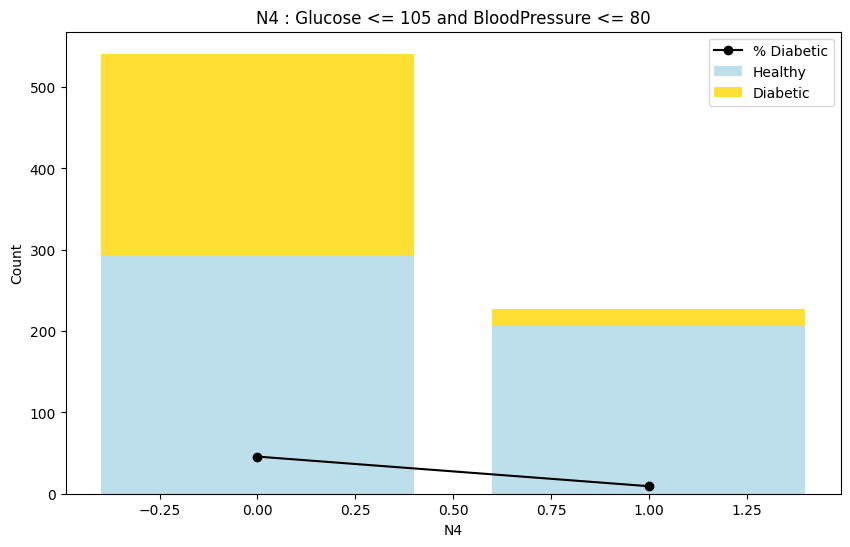

In [ ]:
barplot('N4', ': Glucose <= 105 and BloodPressure <= 80')

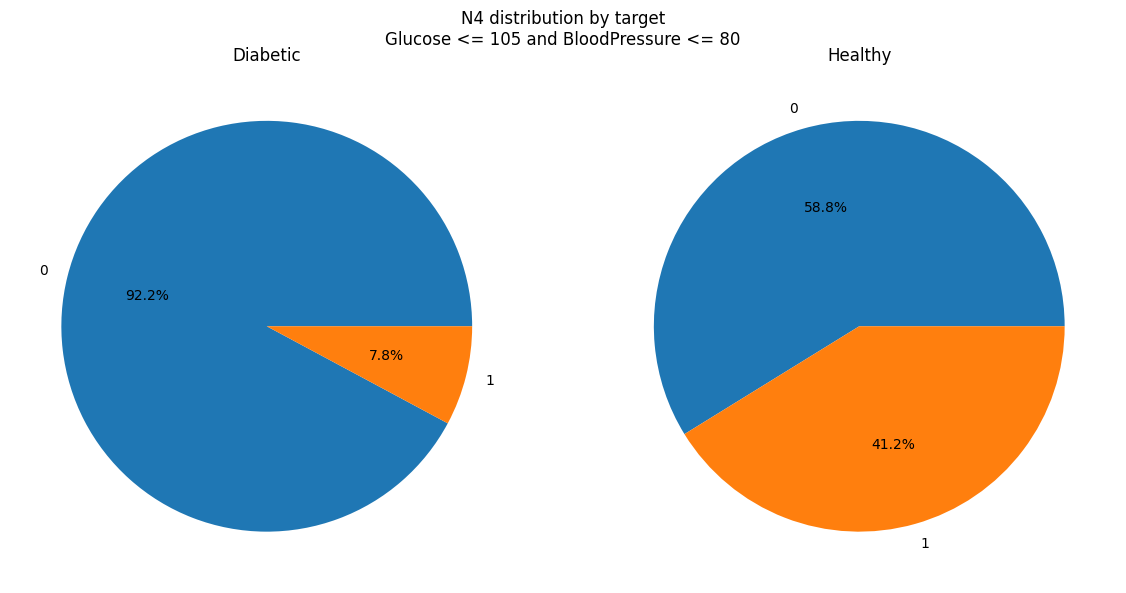

In [ ]:
plot_pie('N4', 'Glucose <= 105 and BloodPressure <= 80')

### Skin Thickness: We measured skin thickness in 66 IDDM patients aged 24-38 yr and investigated whether it correlated with long-term glycemic control and the presence of certain diabetic complications. https://pubmed.ncbi.nlm.nih.gov/2721339/

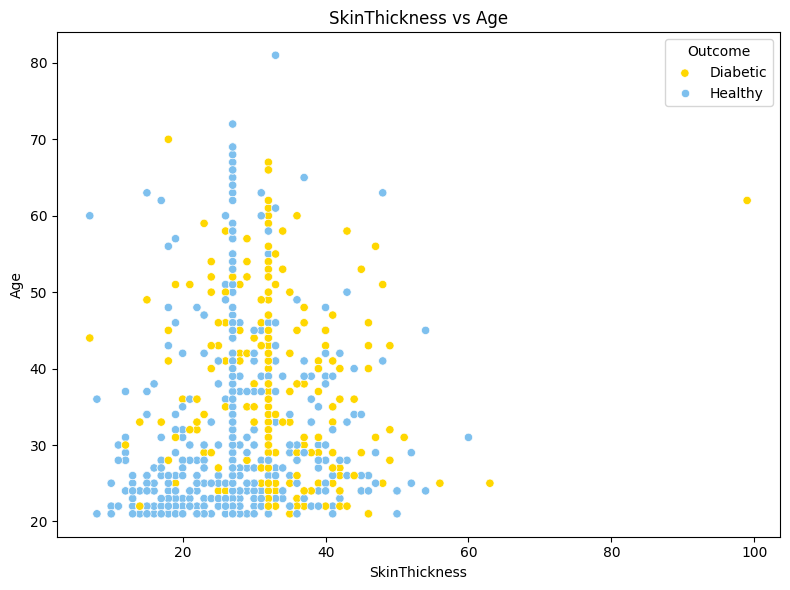

In [ ]:
plot_feat1_feat2('SkinThickness','Age')

In [ ]:
df.loc[:,'N5']=0
df.loc[(df['SkinThickness']<=20) & (df['Age'] <=30) ,'N5']=1

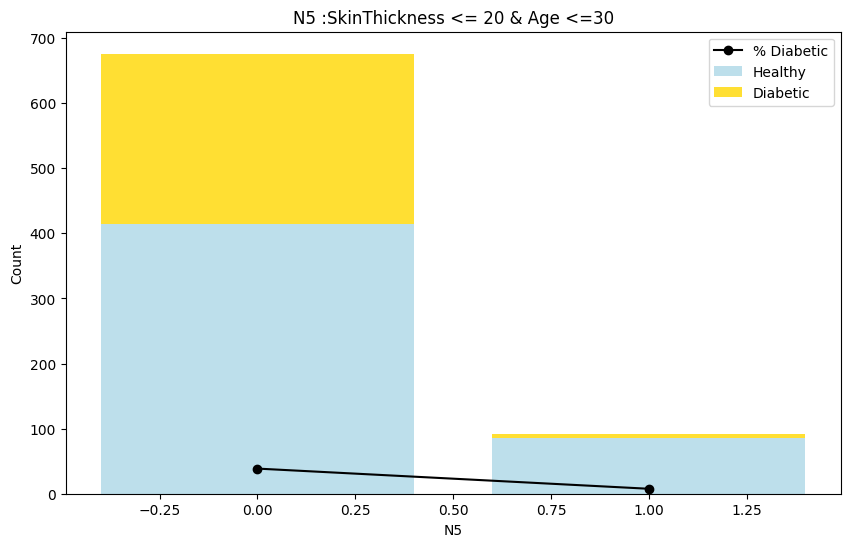

In [ ]:
barplot('N5', ':SkinThickness <= 20 & Age <=30')

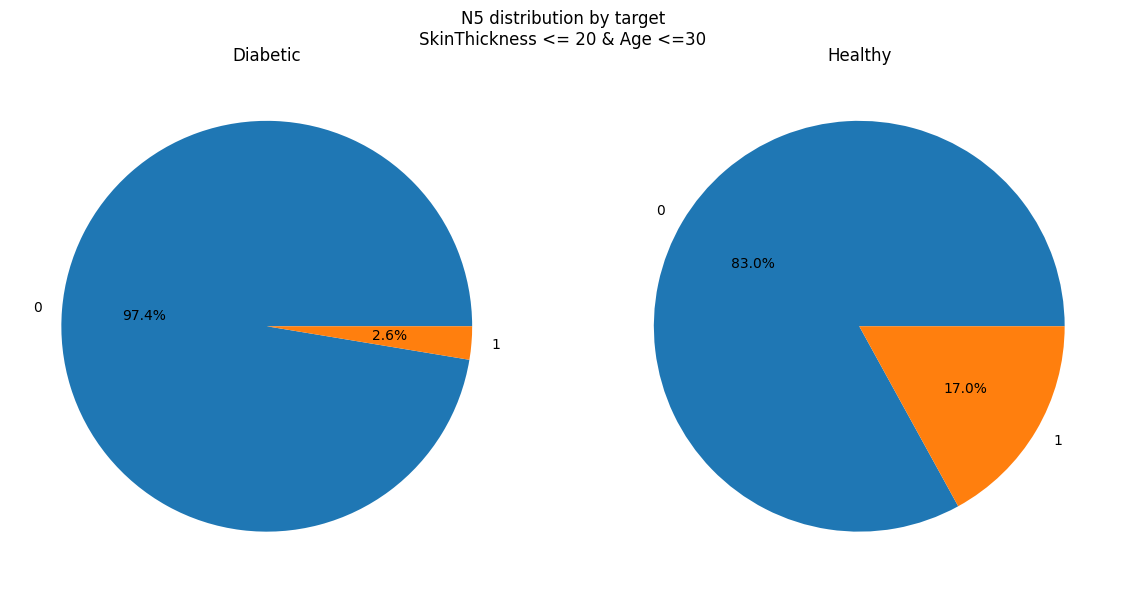

In [ ]:
plot_pie('N5', 'SkinThickness <= 20 & Age <=30')

### Skin Thickness and BMI

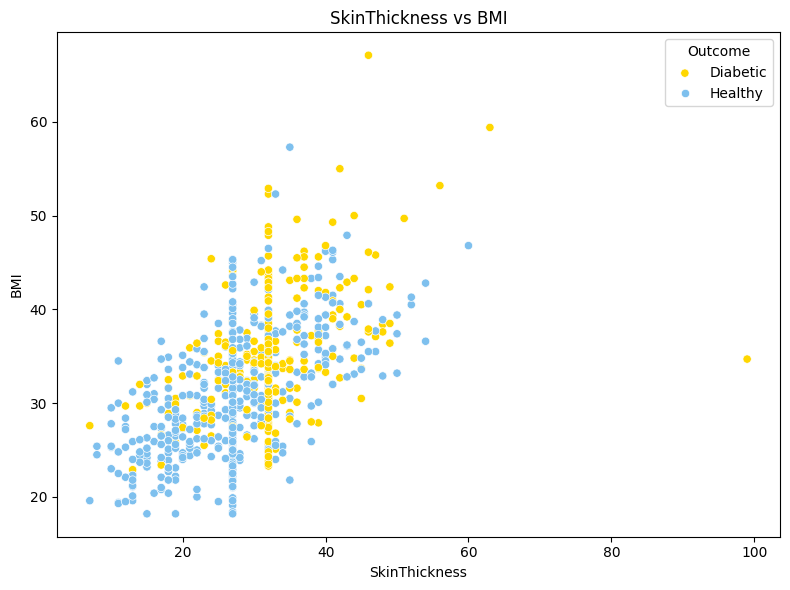

In [ ]:
plot_feat1_feat2('SkinThickness','BMI')

Healthy persons are concentrate with a BMI < 30 and skin thickness <= 20

In [ ]:
df.loc[:,'N6']=0
df.loc[(df['BMI']<30) & (df['SkinThickness']<=20),'N6']=1

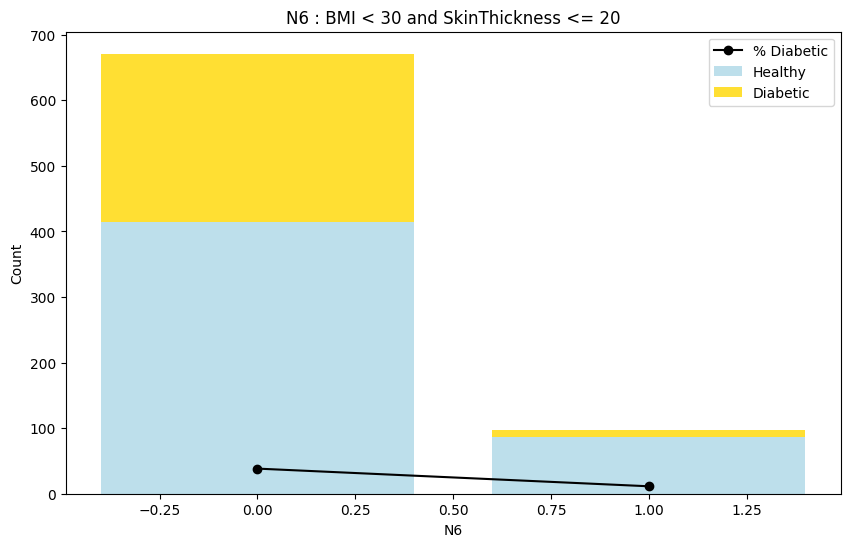

In [ ]:
barplot('N6', ': BMI < 30 and SkinThickness <= 20')

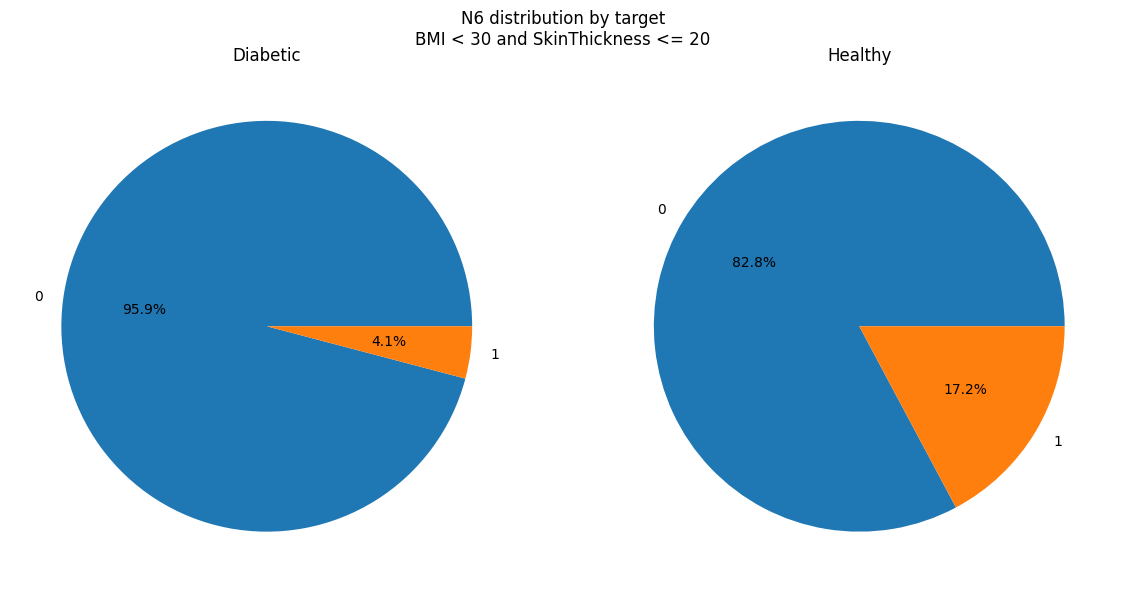

In [ ]:
plot_pie('N6', 'BMI < 30 and SkinThickness <= 20')

### Glucose and BMI

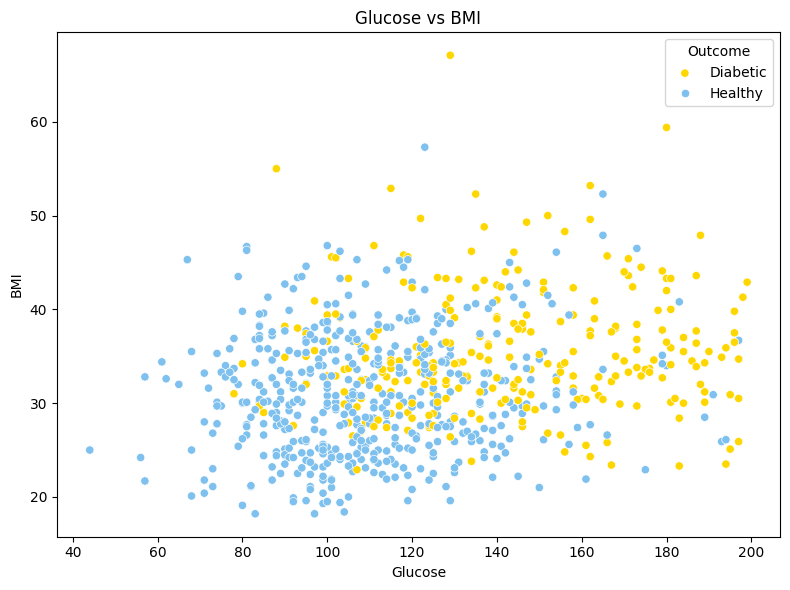

In [ ]:
plot_feat1_feat2('Glucose','BMI')

Healthy person focus on Glucose <=105 and BMI <=30

In [ ]:
df.loc[:,'N7']=0
df.loc[(df['Glucose']<=105) & (df['BMI']<=30),'N7']=1

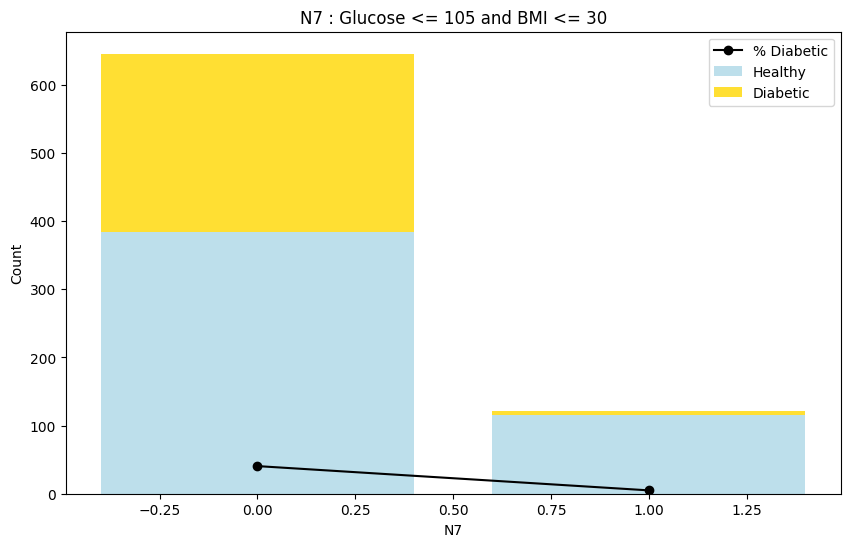

In [ ]:
barplot('N7', ': Glucose <= 105 and BMI <= 30')

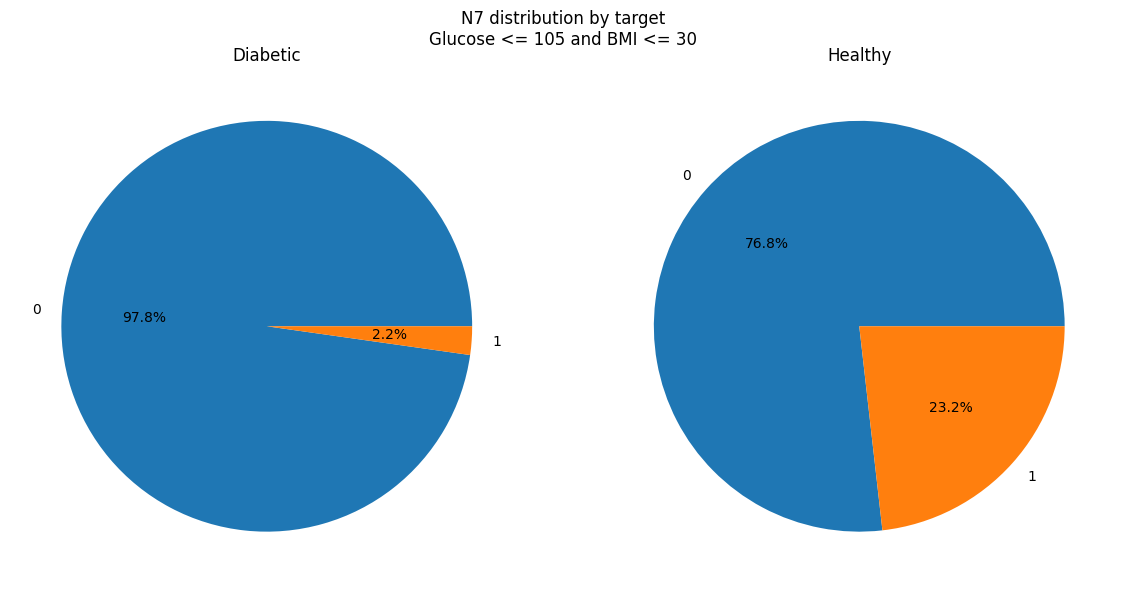

In [ ]:
plot_pie('N7', 'Glucose <= 105 and BMI <= 30')

## Insulin

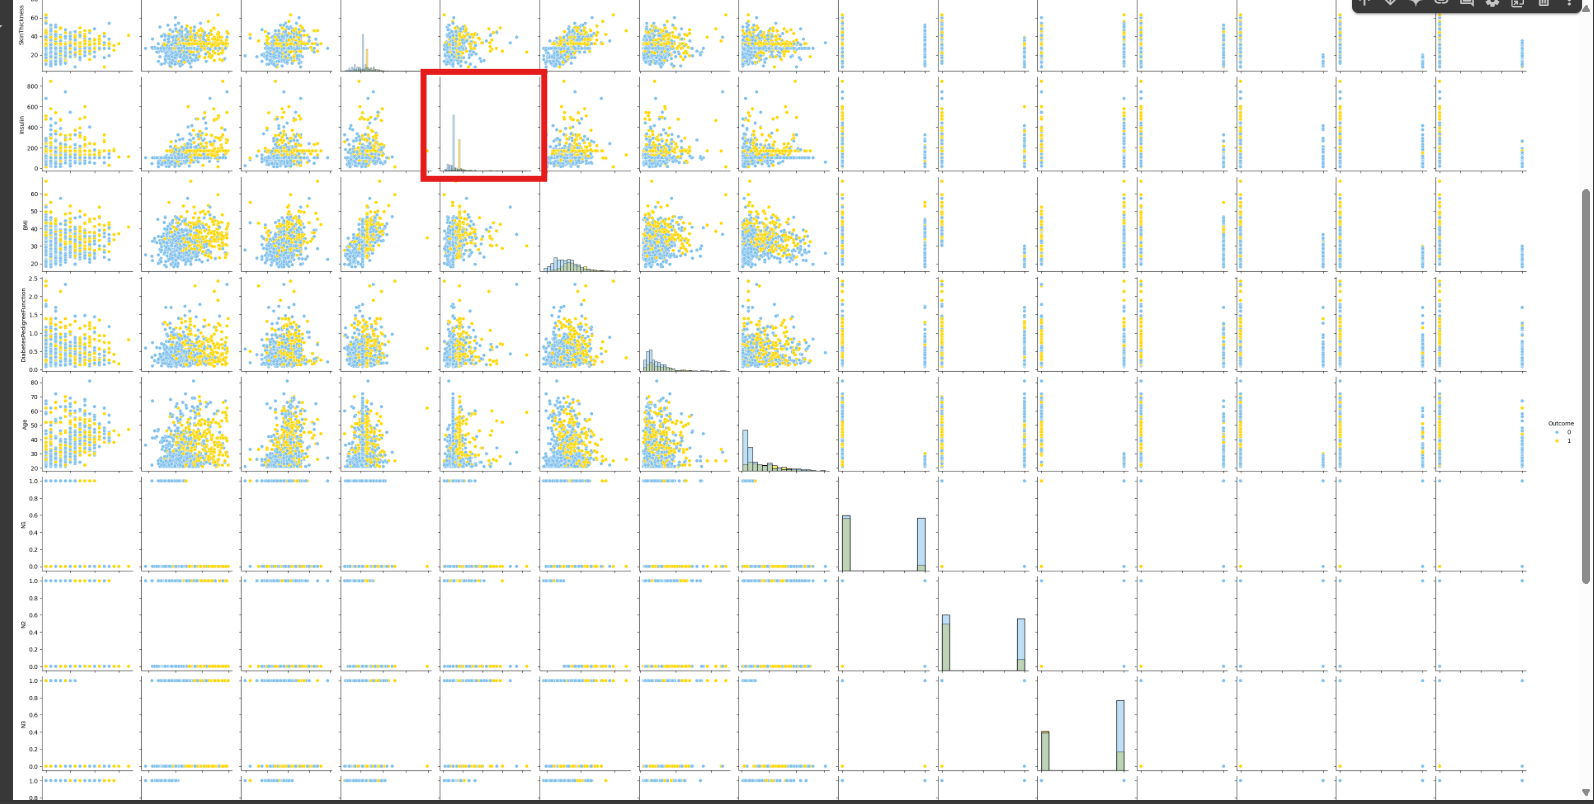

In [ ]:
df.loc[:,'N9']=0
df.loc[(df['Insulin']<200),'N9']=1

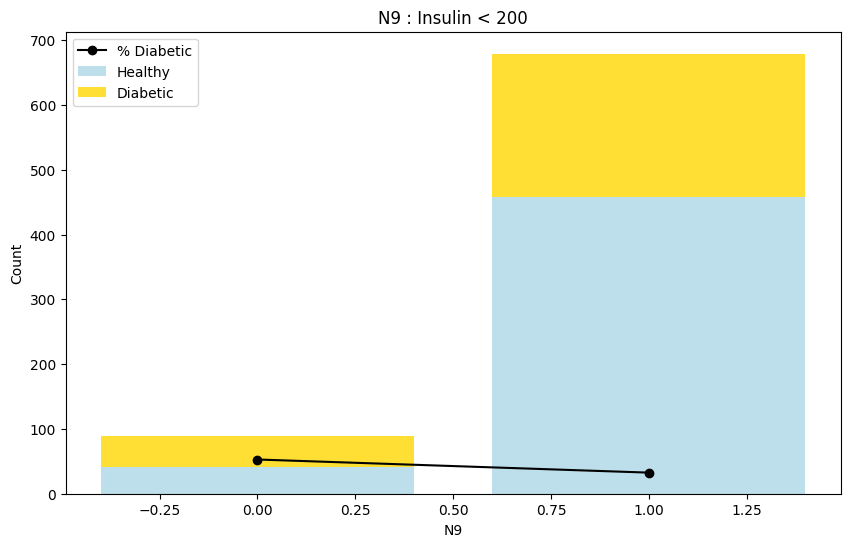

In [ ]:
barplot('N9', ': Insulin < 200')

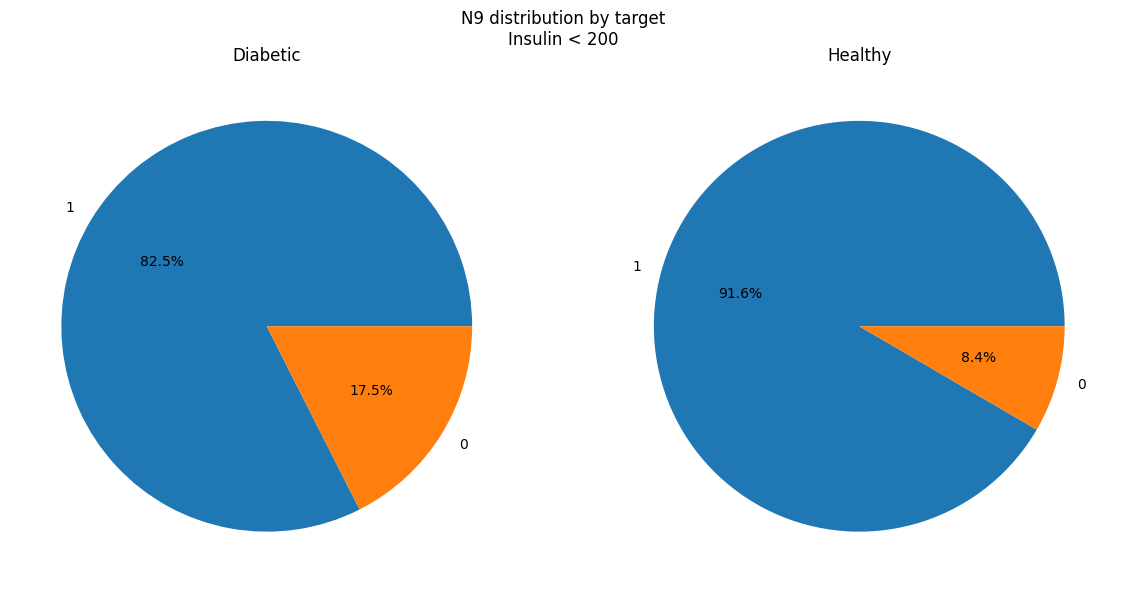

In [ ]:
plot_pie('N9', 'Insulin < 200')

### Blood Pressure: For patients with diabetes, the recommended blood pressure target is generally less than 130/80 mm Hg.

In [ ]:
df.loc[:,'N10']=0
df.loc[(df['BloodPressure']<80),'N10']=1

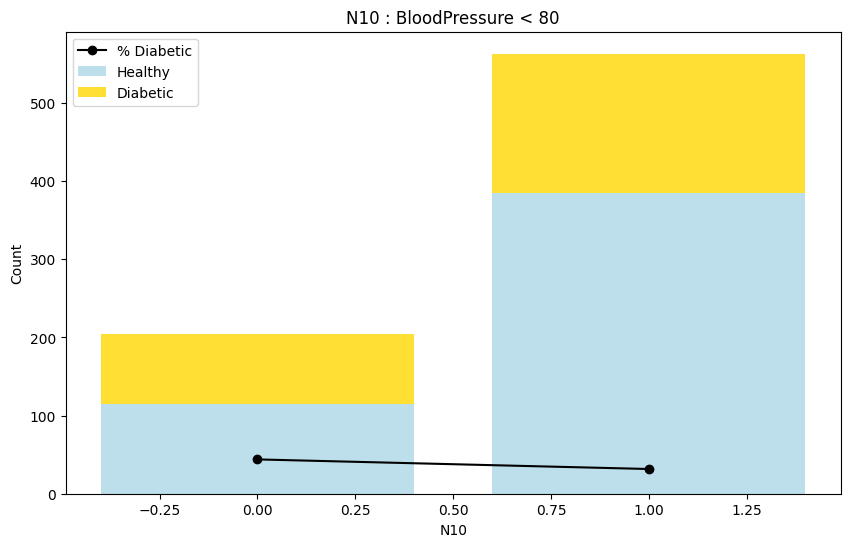

In [ ]:
barplot('N10', ': BloodPressure < 80')

### Pregnancies

In [ ]:
df.loc[:,'N11']=0
df.loc[(df['Pregnancies']<4) & (df['Pregnancies']!=0) ,'N11']=1

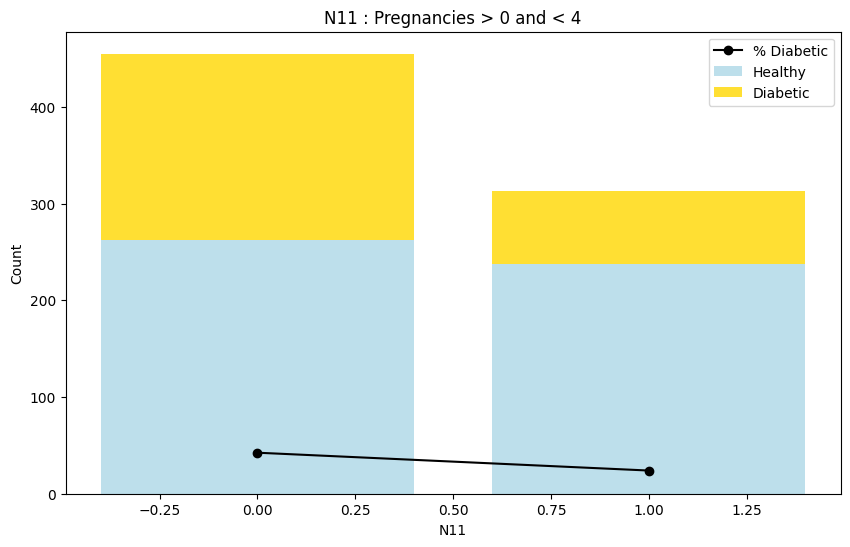

In [ ]:
barplot('N11', ': Pregnancies > 0 and < 4')

In [ ]:
df['N0'] = df['BMI'] * df['SkinThickness'] # If both are high, it might strongly indicate obesity or insulin resistance
df['N8'] =  df['Pregnancies'] / df['Age'] #Higher values may point to early and frequent pregnancies, which is associated with gestational diabetes
df['N13'] = df['Glucose'] / df['DiabetesPedigreeFunction'] #Abnormal someone’s glucose level is compared to their genetic risk
df['N12'] = df['Age'] * df['DiabetesPedigreeFunction'] #The older someone is, the more likely a genetic tendency will show up as diabetes.
df['N14'] = df['Age'] / df['Insulin'] #If an older person has very low insulin, it may suggest the pancreas is failing — a key marker of diabetes

# **Prepare dataset**

StandardScaler and LabelEncoder
StandardScaler: Standardize features by removing the mean and scaling to unit variance. Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the set. Mean and standard deviation are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

LabelEncoder : Encode labels with value between 0 and n_classes-1.
Bellow we encode the data to feed properly to our algorithm

In [ ]:
# Identify columns
target_col = ['Outcome']
cat_cols = [col for col in df.columns if df[col].nunique() < 12 and col not in target_col]
bin_cols = [col for col in cat_cols if df[col].nunique() == 2]
multi_cols = [col for col in cat_cols if col not in bin_cols]
num_cols = [col for col in df.columns if col not in cat_cols + target_col]

# Label encode binary categorical columns
le = LabelEncoder()
for col in bin_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode multi-category columns
df = pd.get_dummies(df, columns=multi_cols)

# Scale numerical columns
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

# Replace original numerical columns with scaled ones
df.drop(columns=num_cols, inplace=True)
df = pd.concat([df, scaled], axis=1)


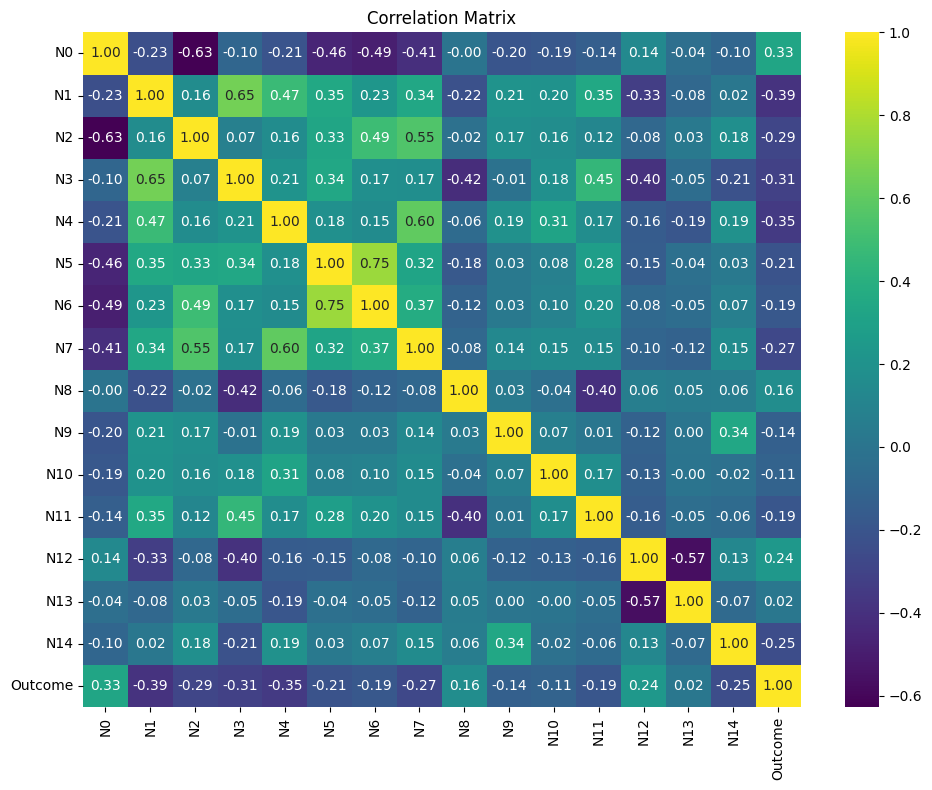

In [ ]:
df_new = df[['N0', 'N1','N2','N3','N4','N5','N6','N7','N8','N9','N10','N11','N12','N13','N14','Outcome']]
correlation_plot(df_new)

# **Model Performance**

In [ ]:
X = df_new.drop('Outcome', axis=1)
y = df_new['Outcome']

### Random Forest

Accuracy: 0.8442
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        99
           1       0.79      0.76      0.78        55

    accuracy                           0.84       154
   macro avg       0.83      0.83      0.83       154
weighted avg       0.84      0.84      0.84       154



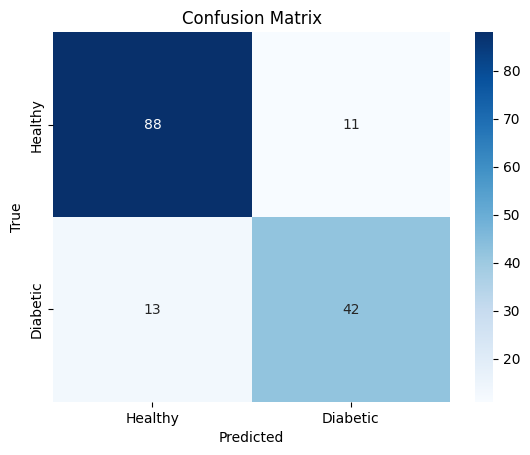

In [ ]:
X = df_new.drop('Outcome', axis=1)  # Features
y = df_new['Outcome']  # Target

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Predictions and Evaluation
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Diabetic'], yticklabels=['Healthy', 'Diabetic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### RandomForest

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.



Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimat

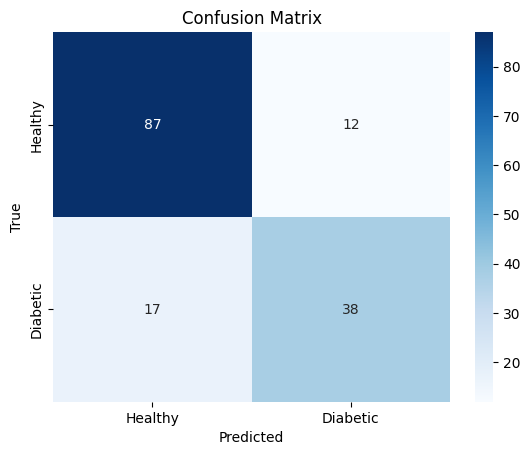

Feature Importances:
N14    0.226607
N0     0.174414
N12    0.121891
N1     0.115381
N13    0.091773
N8     0.078757
N3     0.051747
N2     0.039222
N4     0.035126
N7     0.017778
N11    0.013697
N9     0.011046
N10    0.010566
N5     0.006099
N6     0.005897
dtype: float64


In [ ]:
X = df_new.drop('Outcome', axis=1)  # Features
y = df_new['Outcome']  # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters for RandomizedSearchCV (smaller space)
param_test = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],  # Corrected to 'sqrt' or 'log2'
    'bootstrap': [True],
}

# Reduce number of iterations for RandomizedSearchCV
n_iter = 100

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_test,
                                   n_iter=n_iter, scoring='accuracy', cv=3,  # 3-fold cross-validation
                                   refit=True, random_state=42, verbose=2)

# Fit model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
opt_parameters = random_search.best_params_
print("Best parameters found: ", opt_parameters)

# Train final model with optimal parameters
rf_best = RandomForestClassifier(**opt_parameters, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Evaluate model
y_pred = rf_best.predict(X_test)

# Accuracy and report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Diabetic'], yticklabels=['Healthy', 'Diabetic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importances
feature_importances = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
print('Feature Importances:')
print(feature_importances)

### Logistic Regression Model

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END C=3.7554011884736247, max_iter=100, penalty=l2, solver=saga, tol=0.0001; total time=   0.1s
[CV] END C=3.7554011884736247, max_iter=100, penalty=l2, solver=saga, tol=0.0001; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END C=3.7554011884736247, max_iter=100, penalty=l2, solver=saga, tol=0.0001; total time=   0.1s
[CV] END C=5.9785015794648695, max_iter=200, penalty=l2, solver=saga, tol=0.01; total time=   0.0s
[CV] END C=5.9785015794648695, max_iter=200, penalty=l2, solver=saga, tol=0.01; total time=   0.0s
[CV] END C=5.9785015794648695, max_iter=200, penalty=l2, solver=saga, tol=0.01; total time=   0.0s
[CV] END C=4.602488919658671, max_iter=100, penalty=elasticnet, solver=saga, tol=0.001; total time=   0.0s
[CV] END C=4.602488919658671, max_iter=100, penalty=elasticnet, solver=saga, tol=0.001; total time=   0.0s
[CV] END C=4.602488919658671, max_iter=100, penalty=elasticnet, solver=saga, tol=0.001; total time=   0.0s
[CV] END C=0.5741157902710026, max_iter=200, penalty=elasticnet, solver=lbfgs, tol=0.0001; total time=   0.0s
[CV] END C=0.5741157902710026, max_iter=200, penalty=elasticnet, solver=lbfgs, tol=0.0001; total time=   0.0s
[CV] END C=0.5741157902710026, max_iter=200, penalty=elasticn

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END C=8.814678390152578, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001; total time=   0.0s
[CV] END C=8.814678390152578, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001; total time=   0.0s
[CV] END C=1.064942598302706, max_iter=200, penalty=elasticnet, solver=saga, tol=0.001; total time=   0.0s
[CV] END C=1.064942598302706, max_iter=200, penalty=elasticnet, solver=saga, tol=0.001; total time=   0.0s
[CV] END C=1.064942598302706, max_iter=200, penalty=elasticnet, solver=saga, tol=0.001; total time=   0.0s
[CV] END C=1.2308795470067335, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001; total time=   0.0s
[CV] END C=1.2308795470067335, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001; total time=   0.0s
[CV] END C=1.2308795470067335, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001; total time=   0.0s
[CV] END C=2.7313224938463527, max_iter=300, penalty=elasticnet, solver=liblinear, tol=0.0001; total time=   0.0s
[CV] END C=2.7313224938463527, max_iter=300, penalty=elas

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


153 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1203, in fit
    raise ValueError("l

Accuracy: 0.7922
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        99
           1       0.71      0.71      0.71        55

    accuracy                           0.79       154
   macro avg       0.77      0.77      0.77       154
weighted avg       0.79      0.79      0.79       154



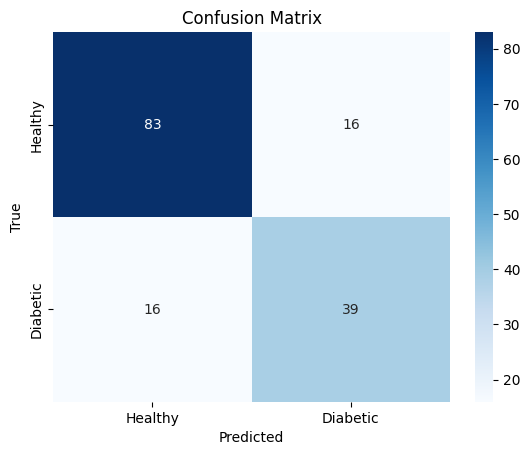

Feature Coefficients:
N9     1.836519
N0     0.720091
N12    0.527255
N5     0.475499
N10    0.374713
N13    0.227318
N6     0.153595
N8     0.051976
N11   -0.018836
N7    -0.393648
N2    -0.614425
N1    -1.084289
N4    -1.103804
N3    -1.625628
N14   -1.747843
dtype: float64


In [ ]:
X = df_new.drop('Outcome', axis=1)  # Features
y = df_new['Outcome']  # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters for RandomizedSearchCV
param_test = {
    'C': uniform(loc=0.01, scale=10),  # Regularization strength (inverse)
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Solvers for Logistic Regression
    'penalty': ['l2', 'elasticnet'],  # Regularization penalty type
    'max_iter': [100, 200, 300],  # Maximum iterations for convergence
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance for stopping criteria
}

# Number of iterations for RandomizedSearchCV
n_iter = 100

# Initialize LogisticRegression model
logreg_model = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=logreg_model, param_distributions=param_test,
                                   n_iter=n_iter, scoring='accuracy', cv=3,  # 3-fold cross-validation
                                   refit=True, random_state=42, verbose=2)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
opt_parameters = random_search.best_params_
print("Best parameters found: ", opt_parameters)

# Train the final model with optimal parameters
logreg_best = LogisticRegression(**opt_parameters, random_state=42)
logreg_best.fit(X_train, y_train)

# Evaluate model
y_pred = logreg_best.predict(X_test)

# Accuracy and report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Diabetic'], yticklabels=['Healthy', 'Diabetic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature coefficients
coefficients = pd.Series(logreg_best.coef_[0], index=X.columns).sort_values(ascending=False)
print('Feature Coefficients:')
print(coefficients)